<img  src="../images/yelp-logo.png" style="width:20%; hieght:20%;" align="left"/>
# Dataset

Sean Wade

## Introduction

Yelp was designed to help people connect with great local businesses.  It is a web community where people rate, review, comment, and share info about businesses all over the world.  This varies from restaurants to auto mechanics.  Yelp has become an integral part in how people decide to eat and find other businesses.  With over 115 million reviews, there is a lot of data to leverage for these decisions. This is powerful and useful data, but it is **LARGE SCALE** data.  It provides an interesting challenge to extract insight.  

Since I am from Phoenix I will be using the Phoenix data to answer the following question:
- Can we predict a businesses rating?
- More specifically, can I get better rating predictions looking at only Mexican restaurants?

## The Raw Data

- **2.7M** reviews and **649K** tips by **687K** users for **86K** businesses
- **566K** business attributes, e.g., hours, parking availability, ambience.
- Social network of **687K** users for a total of **4.2M** social edges.
- Aggregated check-ins over time for each of the **86K** businesses
- **200,000** pictures from the included businesses

### Cities
- **U.K.** :  Edinburgh
- **Germany** :  Karlsruhe
- **Canada** :  Montreal and Waterloo
- **U.S.** :  Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison
<img  src="images/dataset-map.png"/>
*source: yelp.com*

### Data format
The data is formated into several large JSON files.

#### Business
```json
{
    'type': 'business',
    'business_id': (encrypted business id),
    'name': (business name),
    'neighborhoods': [(hood names)],
    'full_address': (localized address),
    'city': (city),
    'state': (state),
    'latitude': latitude,
    'longitude': longitude,
    'stars': (star rating, rounded to half-stars),
    'review_count': review count,
    'categories': [(localized category names)]
    'open': True / False (corresponds to closed, not business hours),
    'hours': {
        (day_of_week): {
            'open': (HH:MM),
            'close': (HH:MM)
        },
        ...
    },
    'attributes': {
        (attribute_name): (attribute_value),
        ...
    },
}
```

#### Review
```json
{
    'type': 'review',
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'stars': (star rating, rounded to half-stars),
    'text': (review text),
    'date': (date, formatted like '2012-03-14'),
    'votes': {(vote type): (count)},
}
```

#### User
```json
{
    'type': 'user',
    'user_id': (encrypted user id),
    'name': (first name),
    'review_count': (review count),
    'average_stars': (floating point average, like 4.31),
    'votes': {(vote type): (count)},
    'friends': [(friend user_ids)],
    'elite': [(years_elite)],
    'yelping_since': (date, formatted like '2012-03'),
    'compliments': {
        (compliment_type): (num_compliments_of_this_type),
        ...
    },
    'fans': (num_fans),
}
```

#### Check-in
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

#### Tip
```json
{
    'type': 'tip',
    'text': (tip text),
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'date': (date, formatted like '2012-03-14'),
    'likes': (count),
}
```

#### Photos
```json
[
    {
        "photo_id": (encrypted photo id),
        "business_id" : (encrypted business id),
        "caption" : (the photo caption, if any),
        "label" : (the category the photo belongs to, if any)
    },
    {...}
]
```

## Limitations

The primary limitation with this data is there are many NaN values and it is sparse data.  These are primarily associated with the attributes of the business. It would be not be reasonable to simply one-hot encode these so special care must be taken to choose which features to use and how to fill the NaN's. Another issue is the massive amount and types of data.  We can not build a successful model by just throwing all the data at it.  To resolve this we will focus on the data described below.

## Test vs. Train

For testing the validity of my model I will shuffle the Phoenix data and then break it into 80% train and 20% test.  Then when I need to check my accuracy I can use the unknown ratings in the test set to come up with an accuracy.  Also I could further explore the robustness of my model to location by testing with the data from the other 29 cities.  It could be interesting to see how my model predictions transfers to different countries.

## Initialize Dataframes

#### Convert JSON to CSV
Since reading data from a JSON file to pandas is difficult, I first convert it to a CSV file.  Sub-categories are denoted with dot notation, i.e. *'votes.funny'*, *'votes.useful'*.

In [16]:
# Import everything here
import json
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pylab import rcParams
import seaborn as sns
from glob import glob
import re
import string
import plotly.plotly as py
from plotly.graph_objs import *
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
py.sign_in('smwade', "a8zcz2zggpeP7MhyykAS")
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.ccs').read())

In [2]:
# NOTE: Slow, do not run unless neccisary. Uncomment to run

def convert(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

# path = './data/json/'

# for json_filename in glob(path + '*.json'):
#     csv_filename = '%s.csv' % json_filename[:-5]
#     print 'Converting %s to %s' % (json_filename, csv_filename)
#     df = pd.DataFrame([convert(line) for line in file(json_filename)])
#     df.to_csv(csv_filename, encoding='utf-8', index=False)

#### Loading the CSV into DataFrames

In [17]:
checkin = pd.read_csv('../raw_data/csv/yelp_academic_dataset_checkin.csv')
business = pd.read_csv('../raw_data/csv/yelp_academic_dataset_business.csv')
tip = pd.read_csv('../raw_data/csv/yelp_academic_dataset_tip.csv')
users = pd.read_csv('../raw_data/csv/yelp_academic_dataset_user.csv')
review = pd.read_csv('../raw_data/csv/yelp_academic_dataset_review.csv')

## Cleaning the Data

Now that we have all the data into pandas DataFrames we need to clean it.  This involves fixing mistakes in the data, dealing with empty values, feature engineering, and dropping data.  Since this data is for all 30 cities we start by grouping the data for Arizona only.

In [18]:
# Groups the data into states and countries
states = business.groupby('state')
az_business = states.get_group('AZ')

In [19]:
az_business.head()

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,neighborhoods,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale
2288,NaN,NaN,NaN,10:00,NaN,NaN,NaN,NaN,10:00,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2376,NaN,NaN,NaN,06:00,NaN,NaN,NaN,NaN,06:00,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2377,False,NaN,NaN,10:00,NaN,NaN,NaN,NaN,10:00,False,...,loud,NaN,casual,NaN,False,[],NaN,False,NaN,False
2378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,quiet,NaN,NaN,NaN,True,[],NaN,NaN,NaN,NaN
2379,NaN,NaN,NaN,08:00,NaN,NaN,NaN,NaN,08:00,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


The fist 5 values are looking good. Next we use the unique business_id to cut all the other DataFrames down to deal with just AZ locations.

In [20]:
# Create a set of valid businesses to check for
business_set = set(az_business['business_id'])

az_review = review[review['business_id'].isin(business_set)]
az_checkin = checkin[checkin['business_id'].isin(business_set)]
az_tip = tip[tip['business_id'].isin(business_set)]

In [21]:
# all the users that left reviews in AZ
az_user = users[users['user_id'].isin(set(az_review['user_id']))]

### Add business name to all dataFrames
To make it easier for human readability (and plotting) we will add the business name as a feature.

In [22]:
print(business[:2])

  attributes.Ambience.divey attributes.Dietary Restrictions.vegan  \
0                     False                                   NaN   
1                       NaN                                   NaN   

  attributes.Happy Hour hours.Thursday.open attributes.Order at Counter  \
0                   NaN               11:00                         NaN   
1                  True                 NaN                         NaN   

  attributes.Hair Types Specialized In.africanamerican  \
0                                                NaN     
1                                                NaN     

  attributes.Hair Types Specialized In.kids attributes.BYOB hours.Friday.open  \
0                                       NaN             NaN             11:00   
1                                       NaN             NaN               NaN   

  attributes.Good For.latenight             ...              \
0                         False             ...               
1                    

In [23]:
business_dict = dict(zip(business['business_id'], business['name']))

In [24]:
az_review['biz_name'] = [business_dict[x] for x in az_review['business_id'].tolist()]
az_checkin['biz_name'] = [business_dict[x] for x in az_checkin['business_id'].tolist()]
az_tip['biz_name'] = [business_dict[x] for x in az_tip['business_id'].tolist()]

In [25]:
az_review[:2]

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,biz_name
43969,b6CL_FrloEX5BdDE10UlcA,tXtIRKfy8I8R09HnSL-siA,The scam of the century! I'm still horrified! ...,0,LUvxyWag5gpiubSxOvR92A,0,1,2014-07-28,review,3,Sleep Number
43970,EdyFJ9zkaCdqrH1VaIIKcA,4n04q5jH-hMJ-7HTfNXnBw,I ordered my bed on 8/31 during the Labor Day ...,0,LUvxyWag5gpiubSxOvR92A,0,1,2014-09-27,review,0,Sleep Number


### Create Categorical Rating Data

For grouping and clustering we will take the continuous *stars* data and group them into groups of 1, 2, 3, 4, and 5.

In [26]:
az_business['star_category'] = pd.cut(az_business['stars'], 5,
           labels=[1, 2, 3, 4, 5])

### Drop Unnecessary Columns

In [27]:
az_business.drop(['neighborhoods','type','full_address', 'state'], inplace=True, axis=1, errors='ignore')

### Missing Data

As mentioned earlier, there are many missing values...

In [28]:
az_business.isnull().sum()

attributes.Ambience.divey                               28331
attributes.Dietary Restrictions.vegan                   36460
attributes.Happy Hour                                   34896
hours.Thursday.open                                     11575
attributes.Order at Counter                             36308
attributes.Hair Types Specialized In.africanamerican    36202
attributes.Hair Types Specialized In.kids               36202
attributes.BYOB                                         36085
hours.Friday.open                                       11785
attributes.Good For.latenight                           27619
attributes.Outdoor Seating                              26449
attributes.Alcohol                                      27371
attributes.Ambience.classy                              28334
attributes.By Appointment Only                          27569
attributes.Parking.lot                                  16950
business_id                                                 0
attribut

Since every data point has a null value for at least one of the *attribute* columns, it would not make sense just to drop them. Instead we will look at how the attributes we do have influence the data and keep the relevant ones. This will be encoded for machine learning with 0-False, 1-True, and 2-Unknown. 

## First look at the Data

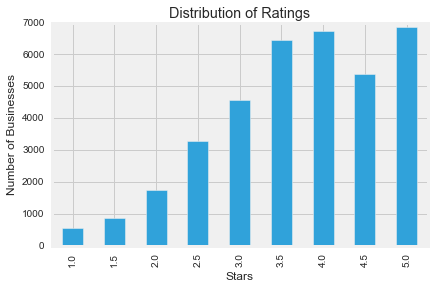

In [29]:
az_business['stars'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')
plt.show()

## Which Attributes are Important

In the business data we have 71 different attributes that the businesses could have! The next goal is to see how these affect the ratings. Does free WiFi improve your rating? Does being open 24 hours lower the rating?  For example we can just look at the starts given for places with the **romantic** attribute .

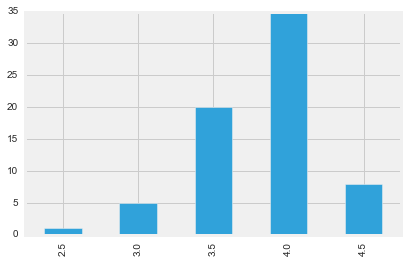

In [30]:
az_business[az_business['attributes.Ambience.romantic'] == True]['stars'].value_counts().sort_index().plot(kind='bar')

This is helpful, but we don't get much information. Plus, there are 71 attributes so we want to extract meaning from all these attributes. The next code is to do just that.

In [31]:
# Make a list of all the attributes and parse them for readability.
pattern = re.compile('attributes*', re.IGNORECASE)
attribute_list = [x for x in list(az_business.columns) if pattern.search(x)]
name_attribute_list = [re.sub('attributes.', '', x) for x in attribute_list]

In [32]:
# Calculate the difference between average rating with or without the attribute.
# NOTE: A negative number means that it hurt the score, while positive helped.

difference_list = []
for attribute in attribute_list:
    group = az_business.groupby(attribute)
    mean = group['stars'].mean()
    try:
        value = -mean[0] + mean[1]
        difference_list.append(value)
    except:
        print attribute + " is not binary. Dropping from graph."    

attributes.Price Range is not binary. Dropping from graph.


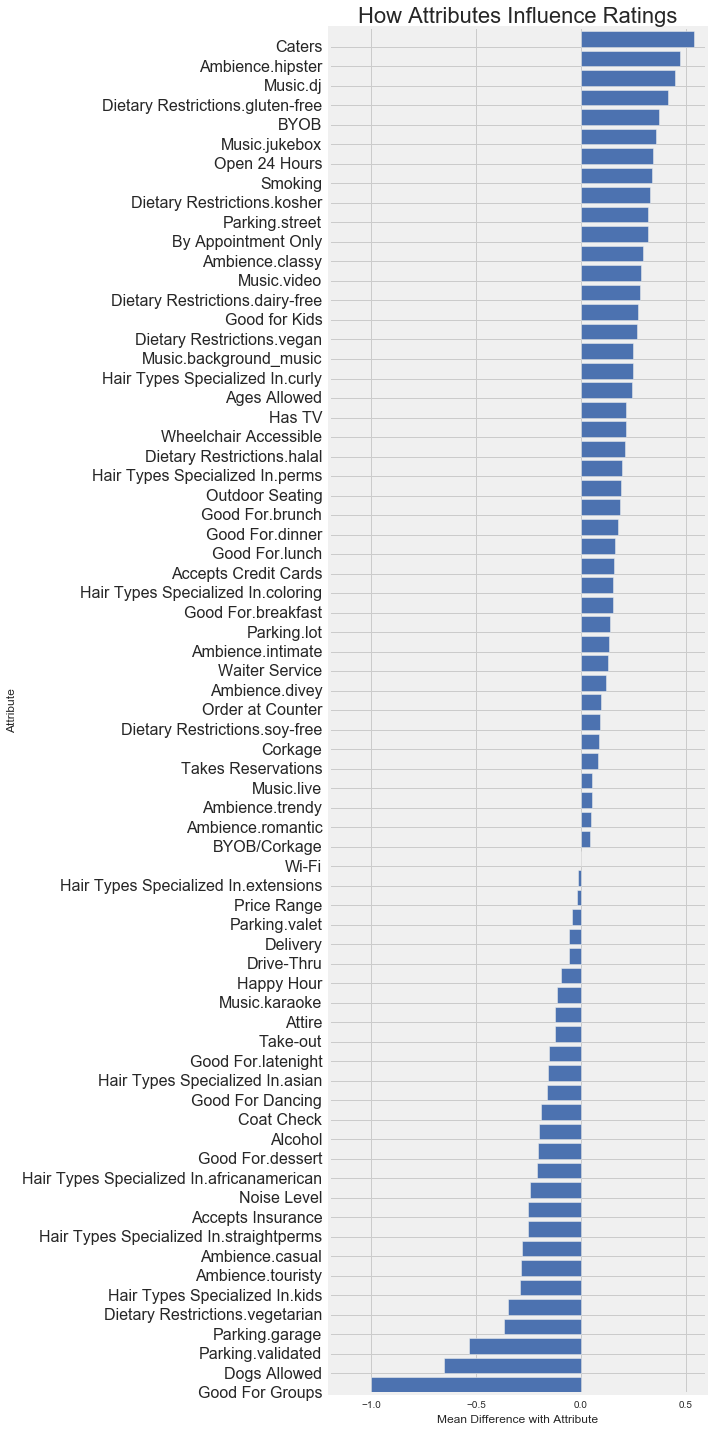

In [23]:
rcParams['figure.figsize'] = 10, 20

# Sort the difference from greatest to least
sorted_args = np.argsort(difference_list)

# Change to np.array for argsort
difference_list = np.array(difference_list)
name_attribute_list = np.array(name_attribute_list)

# Plot the graph
y_pos = np.arange(len(difference_list))
plt.barh(y_pos, difference_list[sorted_args])
plt.yticks(y_pos, name_attribute_list[sorted_args], size=16)
plt.title('How Attributes Influence Ratings', size=22)
plt.xlabel('Mean Difference with Attribute')
plt.ylabel('Attribute')
plt.tight_layout()
plt.show()

This figure is very informative. The attributes on the extremes of the spectrum tell us, on average, whether they lean toward better or worse ratings. For example, if a restaurant caters then it is likely to have .5 more stars than one that does not. Also, strangely, if a business is good for groups its typically a whole star lower. It seems probable that these features will be useful for our model.

## Other attributes in Review Data

In addition to the attributes involved with the business, we also have attributes of the reviews of those businesses.  In yelp other uses can rate reviews as *cool*, *funny*, and *useful*.

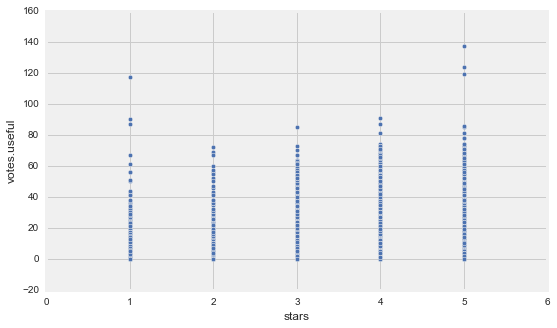

In [24]:
rcParams['figure.figsize'] = 8, 5
az_review.plot(kind='scatter', x='stars', y='votes.useful')

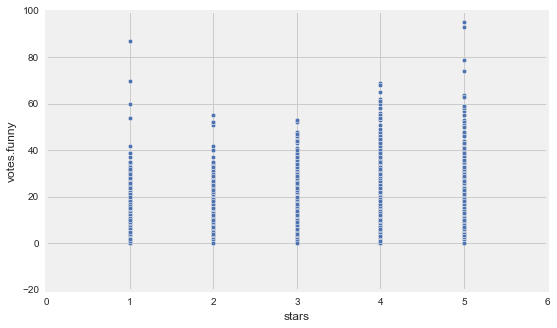

In [25]:
az_review.plot(kind='scatter', x='stars', y='votes.funny')

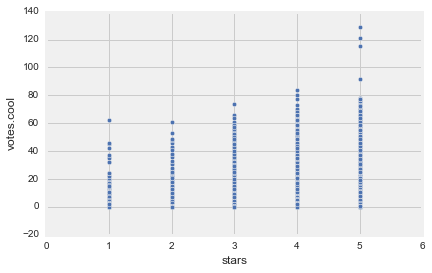

In [40]:
az_review.plot(kind='scatter', x='stars', y='votes.cool')

These three different categories give us surprisingly similar results.  The highest variance in all of them is for 1 and 5 star ratings.  This could be due to the fact that people are more likely to be passionate about really bad and really good experiences.  It is also interesting to note that on average the amount of special votes goes up as the ratings go up.

### One-hot Encoding of Attributes

In [41]:
az_business[attribute_list][:2]

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,attributes.Good For.latenight,attributes.Outdoor Seating,attributes.Alcohol,...,attributes.Dietary Restrictions.vegetarian,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale
2288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
failed_conversion_list = []

for attribute in attribute_list:
    try:
        az_business[attribute] = az_business[attribute].fillna(2).astype(int)
    except:
        print "Did not convert: {}".format(attribute)
        failed_conversion_list.append(attribute)

Did not convert: attributes.Alcohol
Did not convert: attributes.BYOB/Corkage
Did not convert: attributes.Ages Allowed
Did not convert: attributes.Wi-Fi
Did not convert: attributes.Noise Level
Did not convert: attributes.Smoking
Did not convert: attributes.Attire


In [43]:
az_business = az_business.drop(failed_conversion_list, axis=1, errors='ignore')

In [44]:
az_business[:3]

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,attributes.Drive-Thru,attributes.Dietary Restrictions.vegetarian,hours.Wednesday.open,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,star_category
2288,2,2,2,10:00,2,2,2,2,10:00,2,...,2,2,10:00,2,2,2,2,2,2,2
2376,2,2,2,06:00,2,2,2,2,06:00,2,...,2,2,06:00,2,2,2,2,2,2,4
2377,0,2,2,10:00,2,2,2,2,10:00,0,...,2,2,10:00,2,0,2,0,2,0,3


By replacing the NaN's with the value 2 we can plug it as a category into clustering algorithms.

## Locations of Business

There is the classic saying for success in business, "Location, location, location". We now want to explore how true that is. Do successful business cluster together? Or does one really good restaurant bring down the ratings of its neighbors?  To explore this we will plot several maps and then look at statistics for regions.

In [46]:
# Higher density for STD of data

In [45]:
mapbox_access_token = 'pk.eyJ1Ijoic213YWRlIiwiYSI6ImNpdzU4MmR6ZDAwbGwyeHIzcWRkeHNmeWIifQ.dyJ-FEl459ry0ebLOy8f9g'

data = Data([
    Scattermapbox(
        name="Less Than 3 Stars",
        lat=az_business[az_business['stars'] <= 3]['latitude'],
        lon=az_business[az_business['stars'] <= 3]['longitude'],
        mode='markers',
        marker=Marker(
            size=5,
            color='red',
            opacity=0.5,
        ),
        text=az_business[az_business['stars'] <= 3]['name'],
        hoverinfo='text',
    ),
        Scattermapbox(
        name="More Than 3 Stars",
        lat=az_business[az_business['stars'] > 3]['latitude'],
        lon=az_business[az_business['stars'] > 3]['longitude'],
        mode='markers',
        marker=Marker(
            size=5,
            color='blue',
            opacity=0.5,

        ),
        text=az_business[az_business['stars'] > 3]['name'],
        hoverinfo='text',
    )      
])

layout = Layout(
    title="Good vs Bad Business",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=33.4484,
            lon=-112.0740
        ),
        pitch=0,
        zoom=13
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox', validate=False)

The map above breaks our our data into two categories, greater and less than three stars.  After inspecting the map it seems like bad and good businesses are uniformly distributed.  There may be some helpful data from the large clusters in city centers.

### Types of Businesses
We will now engineer some features for different types of businesses to plot. Specifically if it is a restaurant or Mexican food.

In [47]:
food = []
mexican = []
for index, row in az_business['categories'].iteritems():
    food.append('Restaurants' in row)
    mexican.append('Mexican' in row)

In [48]:
az_business['food'] = food
az_business['mexican'] = mexican

In [34]:
mapbox_access_token = 'pk.eyJ1Ijoic213YWRlIiwiYSI6ImNpdzU4MmR6ZDAwbGwyeHIzcWRkeHNmeWIifQ.dyJ-FEl459ry0ebLOy8f9g'

mask = ((az_business['food'] == True) & (az_business['mexican'] == False))

data = Data([
    Scattermapbox(
        name="Mexican",
        lat=az_business[az_business['mexican'] == True]['latitude'],
        lon=az_business[az_business['mexican'] == True]['longitude'],
        mode='markers',
        marker=Marker(
            size=5,
            color='red',
            opacity=0.5,
        ),
        text=az_business[az_business['mexican'] == True]['name'],
        hoverinfo='text',
    ),
        Scattermapbox(
        name="Resturant",
        lat=az_business[mask]['latitude'],
        lon=az_business[mask]['longitude'],
        mode='markers',
        marker=Marker(
            size=5,
            color='blue',
            opacity=0.5,

        ),
        text=az_business[mask]['name'],
        hoverinfo='text',
    )      
])

layout = Layout(
    title="Resturant Locations",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=33.4484,
            lon=-112.0740
        ),
        pitch=0,
        zoom=13
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox', validate=False)

### Clean the city data

Main geographical areas will be very important for understanding the data.  However the dataset is not clean for this.  The cites have duplicate names and misspellings.  To fix this we will get the 5 main cities in the Phoenix Metropolitan are and standardize the spelling.

In [50]:
print list(az_business['city'].unique())

['Chandler', 'Scottsdale', 'Phoenix', 'Glendale', 'Mesa', 'Tempe', 'Florence', 'Peoria', 'Carefree', 'Phoenix, AZ', 'Cave Creek', 'scottsdale', 'Anthem', 'Rio Verde', 'Ahwatukee', 'Pheonix', 'Gilbert', 'MESA', 'Queen Creek', 'Gold Canyon', 'Apache Junction', 'Goldfield', 'Casa Grande', 'Coolidge', 'Higley', 'Sun Lakes', 'Paradise Valley', 'Fort Mcdowell', 'Fountain Hills', 'Maricopa', 'glendale', 'Surprise', 'Arlington', 'Black Canyon City', 'Buckeye', 'Goodyear', 'Litchfield Park', 'Tonopah', 'El Mirage', 'Wickenburg', 'Sedona', 'Tolleson', 'Phoneix', 'Avondale', 'New River', 'Scotesdale', 'Mesa AZ', 'Old Scottsdale', 'Tempe ', 'Guadalupe', 'Sun City', 'Gila Bend', 'Laveen', 'Youngtown', 'Morristown', 'Waddell', 'Wittmann', 'Sun City West', 'Scottdale', 'Payson', 'Roosevelt', 'North Scottsdale', 'Litchfield Park ', 'San Tan Valley', 'Tortilla Flat', 'Mesa ', nan, 'Fort McDowell', 'Peopria', 'Stanfield', 'Tonto Basin', 'MMRP', 'phoenix', 'Litchfield park', 'Grand Canyon', 'Sun City Ant

In [54]:
phoenix_spellings = ["Phoenix", "Phoenix, AZ", 
                     "Pheonix", "Phoneix", "phoenix",
                    "Phoenix", "Phoenix Sky Harbor Center",
                    "Phoenix AZ", "Phoe"]

gilbert_spellings = ["Gilbert", "Chandler-Gilbert", "Gilbert, AZ"]

mesa_spellings = ["Mesa", "MESA", "Mesa AZ", "Mesa "]

tempe_spellings = ["Tempe", "Tempe "]

scottsdale_spellings = ["Scottsdale", "scottsdale", 
                       "Old Scottsdale", "Scottsdale AZ", "SCOTTSDALE"]

In [55]:
az_business['city'] = az_business['city'].replace(phoenix_spellings, "Phoenix")
az_business['city'] = az_business['city'].replace(gilbert_spellings, "Gilbert")
az_business['city'] = az_business['city'].replace(mesa_spellings, "Mesa")
az_business['city'] = az_business['city'].replace(tempe_spellings, "Tempe")
az_business['city'] = az_business['city'].replace(scottsdale_spellings, "Scottsdale")

In [56]:
# We group the data by cities
cities = az_business.groupby('city')

This shows us some important data broken down by major city.

In [57]:
description = cities.describe(exclude=['count'])
description.loc[['Gilbert', 'Phoenix', 'Mesa', 'Tempe', 'Scottsdale'], ['attributes.Price Range', 'review_count', 'stars']]

attributes.Price Range  review_count         stars
city                                                                 
Gilbert    25%                   2.000000      5.000000      3.000000
           50%                   2.000000     10.000000      4.000000
           75%                   2.000000     25.000000      4.500000
           count              1942.000000   1942.000000   1942.000000
           freq                       NaN           NaN           NaN
           max                   4.000000   1368.000000      5.000000
           mean                  1.847065     30.129248      3.786303
           min                   1.000000      3.000000      1.000000
           std                   0.471538     69.900196      0.972527
           top                        NaN           NaN           NaN
           unique                     NaN           NaN           NaN
Mesa       25%                   2.000000      5.000000      3.000000
           50%                   2.000000      9.000000      3.500000
           75%                   2.000000     21.000000      4.500000
           count              3640.000000   3640.000000   3640.000000
           freq                       NaN           NaN           NaN
           max                   4.000000    884.000000      5.000000
           mean                  1.790934     22.319505      3.616896
           min                   1.000000      3.000000      1.000000
           std                   0.504419     43.069610      1.027315
           top                        NaN           NaN           NaN
           unique                     NaN           NaN           NaN
Phoenix    25%                   2.000000      5.000000      3.000000
           50%                   2.000000     10.000000      4.000000
           75%                   2.000000     26.000000      4.500000
           count             11863.000000  11863.000000  11863.000000
           freq                       NaN           NaN           NaN
           max                   4.000000   1938.000000      5.000000
           mean                  1.809576     33.439939      3.685408
           min                   1.000000      3.000000      1.000000
           std                   0.519623     83.380874      1.015412
           top                        NaN           NaN           NaN
           unique                     NaN           NaN           NaN
Scottsdale 25%                   2.000000      5.000000      3.500000
           50%                   2.000000     11.000000      4.000000
           75%                   2.000000     30.000000      4.500000
           count              5644.000000   5644.000000   5644.000000
           freq                       NaN           NaN           NaN
           max                   4.000000   1326.000000      5.000000
           mean                  1.996279     37.786322      3.907247
           min                   1.000000      3.000000      1.000000
           std                   0.552878     84.301912      0.921343
           top                        NaN           NaN           NaN
           unique                     NaN           NaN           NaN
Tempe      25%                   1.000000      5.000000      3.000000
           50%                   2.000000     12.000000      4.000000
           75%                   2.000000     34.000000      4.500000
           count              3044.000000   3044.000000   3044.000000
           freq                       NaN           NaN           NaN
           max                   4.000000   1725.000000      5.000000
           mean                  1.792707     37.294678      3.702037
           min                   1.000000      3.000000      1.000000
           std                   0.519169     79.604256      0.990299
           top                        NaN           NaN           NaN
           unique                     NaN           NaN           NaN

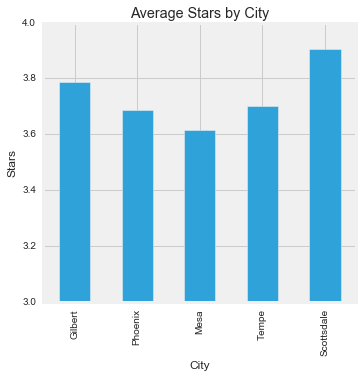

In [40]:
rcParams['figure.figsize'] = 5, 5

mean = cities.mean()
mean.loc[['Gilbert', 'Phoenix', 'Mesa', 'Tempe', 'Scottsdale'], "stars"].plot(kind='bar')
plt.title('Average Stars by City')
plt.ylabel('Stars')
plt.xlabel('City')
plt.ylim(3,4)
plt.show()

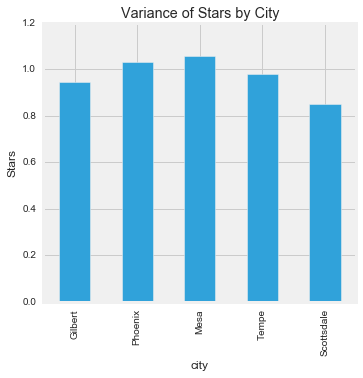

In [41]:
std = cities.var()
std.loc[['Gilbert', 'Phoenix', 'Mesa', 'Tempe', 'Scottsdale'], "stars"].plot(kind='bar')
plt.title('Variance of Stars by City')
plt.ylabel('Stars')
plt.show()

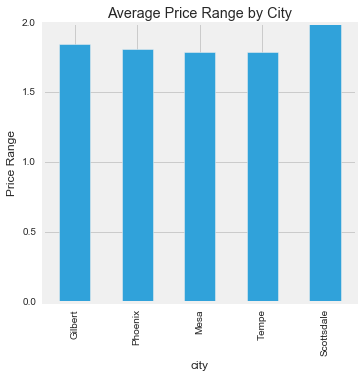

In [42]:
mean = cities.mean()
mean.loc[['Gilbert', 'Phoenix', 'Mesa', 'Tempe', 'Scottsdale'], "attributes.Price Range"].plot(kind='bar')
plt.title('Average Price Range by City')
plt.ylabel('Price Range')
plt.show()

These plots back up some prior knowledge I have about these cities.  Scottsdale is known for having the best but expensive food.  Mesa also is very inconsistent and has the greatest variance in ratings.  This data by major city is helpful but not as helpful as I predicted it would be.

## What about Reviewers?

While there are many great features in the business and review dataFrames, there is a lot that we can learn from the users profiles.  This data comes with the following categories:

In [59]:
list(az_user.columns)

['yelping_since',
 'compliments.plain',
 'review_count',
 'friends',
 'compliments.cute',
 'compliments.writer',
 'fans',
 'compliments.note',
 'type',
 'compliments.hot',
 'compliments.cool',
 'compliments.profile',
 'average_stars',
 'compliments.more',
 'elite',
 'name',
 'user_id',
 'votes.cool',
 'compliments.list',
 'votes.funny',
 'compliments.photos',
 'compliments.funny',
 'votes.useful']

By knowing this data we can see how reliable a user's review is.  We can see their network with others and how influential they are.  High profile users can possibly have a very strong influence on the rating of a business. Review count and where can show quality reviews for specific places, like Indian food or spas.

### Create a Boolean for Ever Elite User

Probably one of the most useful features in users is elite information. If a user has ever been an elite user, meaning lots of respected reviews, then they should be very reliable for determining the rating of a business. We will feature engineer a new column ever_elite that is a boolean for the user.

In [60]:
elite_count = az_user['elite'].apply(lambda x: len(x))
elite_count = [0 if x == 2 else 1 for x in elite_count]
az_user['ever_elite'] = elite_count

In [61]:
print "Number of Elite Users in Phoenix:" , az_user['ever_elite'].sum()

Number of Elite Users in Phoenix: 8903


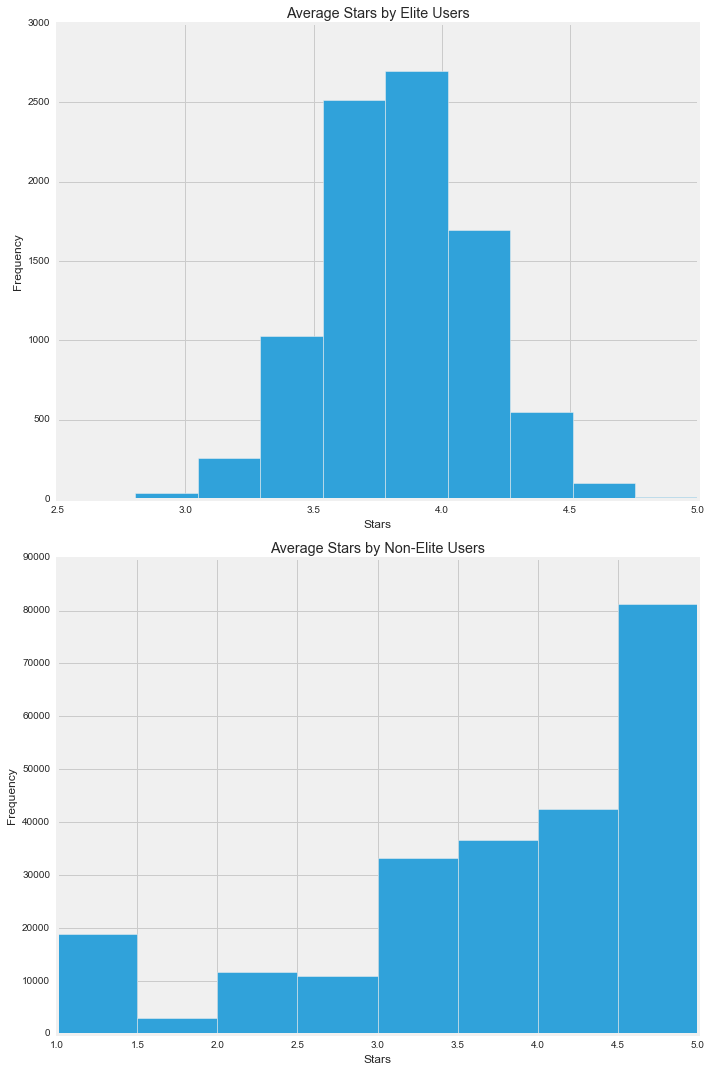

In [62]:
rcParams['figure.figsize'] = 10, 15

plt.subplot(211)
az_user[az_user['ever_elite'] == 1]['average_stars'].plot(kind='hist')

plt.title('Average Stars by Elite Users')
plt.xlabel('Stars')

plt.subplot(212)
az_user[az_user['ever_elite'] == 0]['average_stars'].plot(kind='hist')
plt.title('Average Stars by Non-Elite Users')
plt.xlabel('Stars')
plt.xlim(1,5)
plt.tight_layout()
plt.show()

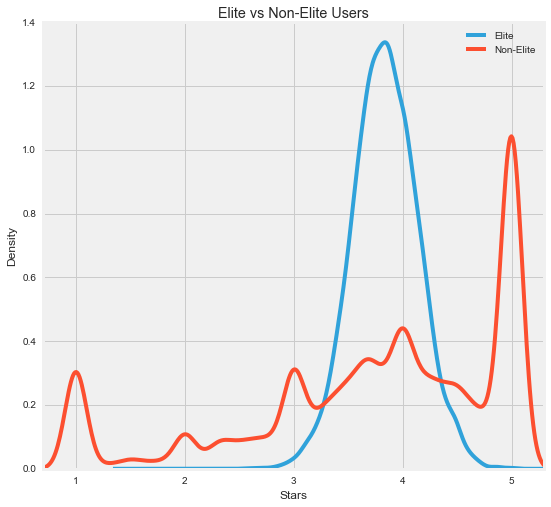

In [47]:
rcParams['figure.figsize'] = 8, 8

az_user[az_user['ever_elite'] == 1]['average_stars'].plot(kind='kde', label='Elite')
az_user[az_user['ever_elite'] == 0]['average_stars'].plot(kind='kde', label='Non-Elite')
plt.legend()
plt.title('Elite vs Non-Elite Users')
plt.xlabel('Stars')
plt.xlim(.7,5.3)
plt.show()

This figure provides an interesting insight to user behavior. The best and most reliable users seem to be normally distributed around the 4 and moderate with their ratings. On the other hand, average users are much more extreme on the positive and negative side of the spectrum.  When making my model I will make sure to weight elite user reviews heavier.

## Review Text
The review text has been cleaned, so it is ready for NLP.  However, even something as simple as the number of characters in a review can give us some helpful information.

In [48]:
az_review['text_length'] = az_review['text'].apply(len)

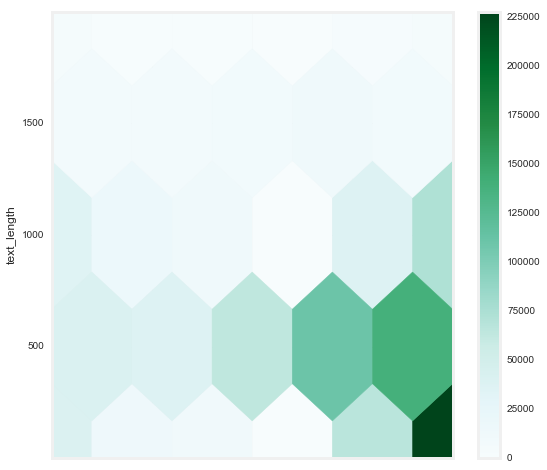

In [49]:
az_review[az_review['text_length'] < 2000].plot(kind='Hexbin', x='stars', y='text_length', gridsize=5)

## Final Data Test-Train Split
Now that the cleaning and feature engineering is done we can split the data for machine learning training.

In [50]:
train, test = train_test_split(az_business, test_size = 0.2)

In [51]:
# Split our test and training from the classification goal
# ---------------------------------------------------
train_rating = train['stars']
train_business = train.drop('stars',axis=1)

test_rating = test['stars']
test_business = test.drop('stars',axis=1)

In [52]:
train_rating.head()

52986    5.0
55418    4.0
51668    4.5
85514    5.0
4206     4.0
Name: stars, dtype: float64

In [53]:
train_business

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,hours.Wednesday.open,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,star_category,food,mexican
52986,2,2,2,NaN,2,2,2,2,NaN,2,...,NaN,2,2,2,2,2,2,5,False,False
55418,0,2,2,11:00,2,2,2,2,11:00,0,...,11:00,2,1,2,0,2,0,4,True,False
51668,2,2,2,08:00,2,2,2,2,08:00,2,...,08:00,2,2,2,2,2,2,5,False,False
85514,2,2,2,NaN,2,2,2,2,NaN,2,...,15:00,2,2,2,2,2,2,5,True,False
4206,2,2,2,08:00,2,2,2,2,08:00,2,...,08:00,2,2,2,2,2,2,4,False,False
42985,2,2,2,09:30,2,2,2,2,09:30,2,...,09:30,2,2,2,2,2,2,4,False,False
68465,2,2,2,10:00,2,2,2,2,10:00,2,...,10:00,2,2,2,2,2,2,4,False,False
80975,2,2,2,06:00,2,2,2,2,06:00,2,...,06:00,2,2,2,2,2,2,4,False,False
15628,2,2,2,NaN,2,2,2,2,NaN,2,...,NaN,2,2,2,2,2,2,4,False,False
6703,2,2,2,08:00,2,2,2,2,08:00,2,...,08:00,2,2,2,2,2,2,3,False,False


In [51]:
az_business.to_csv('az_business.csv', index=False)
az_user.to_csv('az_user.csv', index=False)
az_review.to_csv('az_review.csv', index=False)

## Other Data
There are two other main sources of data

### Photos

<div >
<img src='./images/ex1.jpg' style="width:15%; height:15%; display:inline;margin:5px"/>
<img src='./images/ex2.jpg' style="width:15%; height:15%; display:inline;margin:5px"/>
<img src='./images/ex3.jpg' style="width:15%; height:15%; display:inline;margin:5px"/>
<img src='./images/ex4.jpg' style="width:15%; height:15%; display:inline;margin:5px"/>

</div>

### Review Text

*"The scam of the century! I'm still horrified! Please do not believe the shop assistants in this store!"*

*"We took my 2.5 year old grandson for a cut and he got the full treatment. Omar did a great job working with our little one that wanted to get a big boy hair cut but was a little nervous. He got to watch Sesame Street while the barber worked his magic. He then got a (warm) hot towel for his face and a little massage. It was perfect!"*

*"i stayed for two nights earlier this week. I loved the personality and character of the building and decorating, and appreciated the staff who gave personal attention in an effective and professional way with a smile and hello."*

<hr> 
There is no cleaning that needs to be done since the photos come at the same resolution and the text is cleaned. These two sources of data contain a lot of information, but it is very difficult to extract.  I will be using the photos next semester with a convolutional neural network for multi label generation.  I will be using natural language processing with the reviews for sentiment analysis.

## Conclusion

There are many factors that go into rating a business.  There is the type of product sold, atmosphere, neighborhood, age, and reputation to name a few.  Yelp has provided lots of raw data to answer this question.  This notebook has cleaned the data to a useful form and looked at some relations.  

To start, the data has been cleaned to focus on the Phoenix metro area. It has further been cleaned by removing unnecessary columns, changing the unique ID's to a human readable format, replacing NaN's, and fixing typos.  Special care has been taken to make these changes consistent with the other dataframes, such as `az_review` and `az_user`.

With these clean data we explored several different relationships.  We saw how every individual relationship effected the total rating.  We saw the influence of location on rating.  We even analyzed the users behavior to identify the validity/weight of the ratings.  This knowledge will be injected into future models as a prior.

Even from purely statistical analysis we can see many patterns and insights.  Now that the data is in an appropriate format it will be exciting to see how accurate we can approximate business ratings with machine learning!